# Smart Bin Model

## Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import os

from PIL import Image
import io
import json
import pathlib

In [2]:
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense, Input, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, Callback
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import MobileNetV2

In [3]:
print(tf.__version__)

2.11.1


In [4]:
tf.config.set_visible_devices([], 'GPU')

In [5]:
print(tf.config.list_physical_devices('GPU'))

[]


In [6]:
import GPUtil

gpus = GPUtil.getGPUs()
for gpu in gpus:
    print(f"GPU id: {gpu.id}, name: {gpu.name}, load: {gpu.load*100}%, free memory: {gpu.memoryFree}MB, used memory: {gpu.memoryUsed}MB, total memory: {gpu.memoryTotal}MB, temperature: {gpu.temperature} °C")


GPU id: 0, name: NVIDIA GeForce GTX 1650, load: 27.0%, free memory: 3860.0MB, used memory: 78.0MB, total memory: 4096.0MB, temperature: 49.0 °C


## Data Path Preparation

### Create Path

In [7]:
main_dir = 'Dataset'

In [8]:
if os.path.exists(main_dir):
    for subdir_name in os.listdir(main_dir):
        subdir_path = os.path.join(main_dir, subdir_name)

        if os.path.isdir(subdir_path):
            print(f'Memproses subdir: {subdir_path}')           

Memproses subdir: Dataset\Can
Memproses subdir: Dataset\Plastic Bottle
Memproses subdir: Dataset\UBC


In [9]:
data_paths = []
labels = []

class_list = os.listdir(main_dir)

for classes in class_list:
    class_path = os.path.join(main_dir, classes)
    if os.path.isdir(class_path):
        file_list = os.listdir(class_path)
        for file in file_list:
            f_path = os.path.join(class_path, file)
            data_paths.append(f_path)
            labels.append(classes)

In [10]:
# Path Checking

F_series = pd.Series(data_paths, name='file_paths')
L_series = pd.Series(labels, name='labels')

data_df = pd.concat([F_series, L_series], axis=1)

print(data_df.head())
print(data_df['labels'].value_counts())

                                          file_paths labels
0  Dataset\Can\-2-_jpeg.rf.43dc833156af33fd174c94...    Can
1  Dataset\Can\-3-_jpeg.rf.8cacea1374fba60c6f5ed2...    Can
2  Dataset\Can\-_jpeg.rf.5cb94a5cad118144c78be418...    Can
3  Dataset\Can\1000_F_342875993_cFbHaeM6BvYEbNMu2...    Can
4  Dataset\Can\1000_F_484674280_e2mhjTx7lqxK3FlJ9...    Can
labels
UBC               3620
Plastic Bottle    3461
Can               3450
Name: count, dtype: int64


## Data Split

In [11]:
train_size = 0.8 
test_size = 0.2

In [12]:
train_set, test_set = train_test_split(data_df, test_size=test_size, shuffle=True, stratify=data_df['labels'], random_state=42)

print('train_set length:', len(train_set), 'test_set length:', len(test_set))


train_set length: 8424 test_set length: 2107


## Preprocessing

### Standarisasi

In [13]:
# Standarisasi Data
height = 224
width = 224
channels = 3
batch_size = 512
img_shape = (height, width, channels)
img_size = (height, width)

### Augmentation

In [14]:
train_datagen = ImageDataGenerator(
    rescale= 1.0/255.0,
    rotation_range= 20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range= 0.2,
    horizontal_flip= True,
    fill_mode= 'nearest'
)

In [15]:
# Train Data
train_gen = train_datagen.flow_from_dataframe(train_set,
                                        x_col='file_paths',
                                        y_col= 'labels',
                                        target_size= img_size,
                                        class_mode= 'categorical',
                                        color_mode= 'rgb',
                                        shuffle= True,
                                        batch_size= batch_size
                                        )

Found 8424 validated image filenames belonging to 3 classes.


In [16]:
test_datagen = ImageDataGenerator(
    rescale= 1./255.
)

In [17]:
# Test Data
test_gen = test_datagen.flow_from_dataframe(test_set,
                                        x_col='file_paths',
                                        y_col= 'labels',
                                        target_size= img_size,
                                        class_mode= 'categorical',
                                        color_mode= 'rgb',
                                        shuffle= True,
                                        batch_size= batch_size
                                        )

Found 2107 validated image filenames belonging to 3 classes.


In [18]:
train_categories = list(train_gen.class_indices.keys())
print(train_categories)

['Can', 'Plastic Bottle', 'UBC']


## Data Checking

### Show Images

In [19]:
from PIL import UnidentifiedImageError

def open_image(image_path):
    try:
        with Image.open(image_path) as img:
            pass
    except UnidentifiedImageError:
        print(f"File {image_path} tidak dikenali atau rusak. Menghapus file.")
        os.remove(image_path)
    except Exception as e:
        print(f"Terjadi kesalahan saat membuka {image_path}: {e}")

def process_images_in_folder(root_folder):
    for root, dirs, files in os.walk(root_folder):
        for file in files:
            file_path = os.path.join(root, file)
            if file.lower().endswith(('png', 'jpg', 'jpeg', 'gif', 'bmp')):  # Tambahkan format gambar yang diperlukan
                open_image(file_path)

root_folder_path = 'Dataset'
process_images_in_folder(root_folder_path)

In [20]:
def show_samples(generator):
    images, labels = next(generator)
    plt.figure(figsize= (20, 20))
    for i in range(min(len(labels), 20)):
        plt.subplot(5, 4, i + 1)
        plt.imshow(images[i])
        index = np.argmax(labels[i])
        class_name = train_categories[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

In [21]:
print(data_df['labels'].value_counts())

labels
UBC               3620
Plastic Bottle    3461
Can               3450
Name: count, dtype: int64


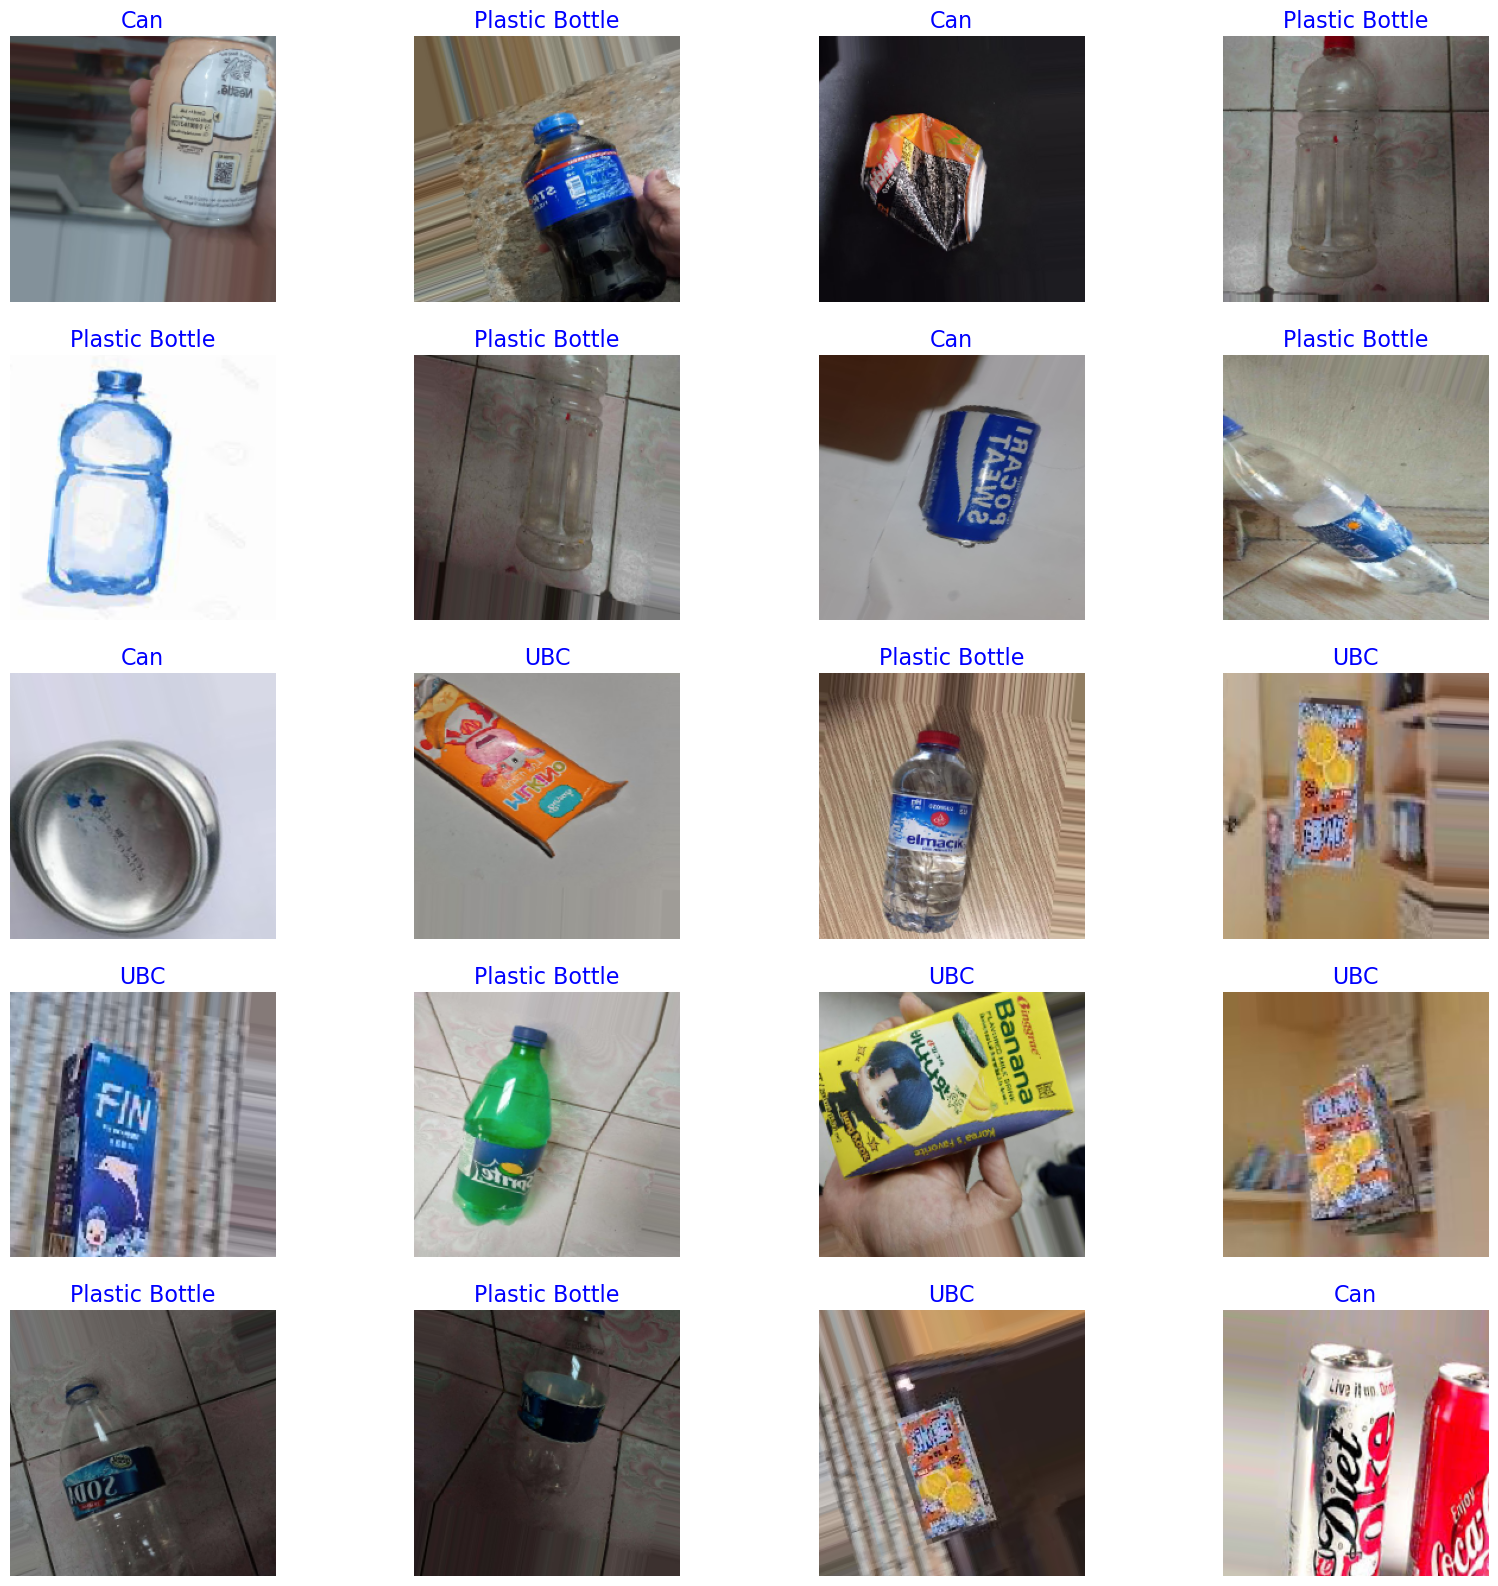

In [22]:
show_samples(train_gen)

## Model

### Design

In [23]:
num_classes = len(classes)

base_model = MobileNetV2(weights="imagenet", include_top=False,
                                input_shape=img_shape)
for layer in base_model.layers:
    layer.trainable = False

extractor = Model(inputs=base_model.input, outputs=base_model.get_layer('block_15_project_BN').output)

In [24]:
extractor_output_shape = extractor.output_shape
print("Extractor output shape:", extractor_output_shape)

Extractor output shape: (None, 7, 7, 160)


In [25]:
model = Sequential([
    extractor,
    Conv2D(160, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(80, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(rate=0.5),
    Flatten(),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Build the model
model.build((None, *img_shape))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 7, 7, 160)         1364864   
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 160)         230560    
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 160)        640       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 160)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 80)          115280    
                                                                 
 batch_normalization_1 (Batc  (None, 3, 3, 80)         3

### Training

In [26]:
# Early Stopping
class CustomEarlyStopping(Callback):
    def __init__(self, accuracy_threshold=0.96):
        super(CustomEarlyStopping, self).__init__()
        self.accuracy_threshold = accuracy_threshold

    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get("accuracy")
        val_accuracy = logs.get("val_accuracy")
        if accuracy >= self.accuracy_threshold and val_accuracy >= self.accuracy_threshold:
            print(f"\nTraining stopped at epoch {epoch + 1}")
            self.model.stop_training = True

In [27]:
custom_early_stopping = CustomEarlyStopping(accuracy_threshold=0.96)

In [28]:
history = model.fit(train_gen, 
                    epochs=30, 
                    validation_data=test_gen,
                    steps_per_epoch=len(train_set) // batch_size,
                    validation_steps=len(test_set) // batch_size, 
                    callbacks=[custom_early_stopping]
)

Epoch 1/30
16/16 [==============================] - 430s 26s/step - loss: 0.9712 - accuracy: 0.7658 - val_loss: 2.3260 - val_accuracy: 0.8735
Epoch 2/30
16/16 [==============================] - 395s 25s/step - loss: 0.2982 - accuracy: 0.8885 - val_loss: 0.8617 - val_accuracy: 0.8931
Epoch 3/30
16/16 [==============================] - 398s 25s/step - loss: 0.2225 - accuracy: 0.9156 - val_loss: 0.4706 - val_accuracy: 0.9111
Epoch 4/30
16/16 [==============================] - 403s 25s/step - loss: 0.1787 - accuracy: 0.9336 - val_loss: 0.3362 - val_accuracy: 0.9199
Epoch 5/30
16/16 [==============================] - 385s 24s/step - loss: 0.1584 - accuracy: 0.9427 - val_loss: 0.2728 - val_accuracy: 0.9204
Epoch 6/30
16/16 [==============================] - 420s 26s/step - loss: 0.1293 - accuracy: 0.9559 - val_loss: 0.1626 - val_accuracy: 0.9438
Epoch 7/30
16/16 [==============================] - 352s 23s/step - loss: 0.1142 - accuracy: 0.9569 - val_loss: 0.1648 - val_accuracy: 0.9424
Epoch 

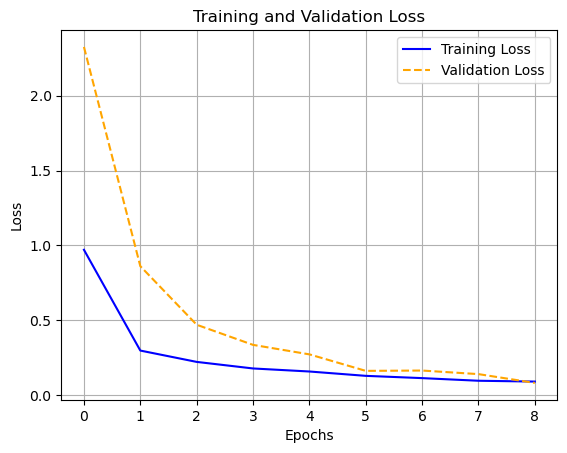

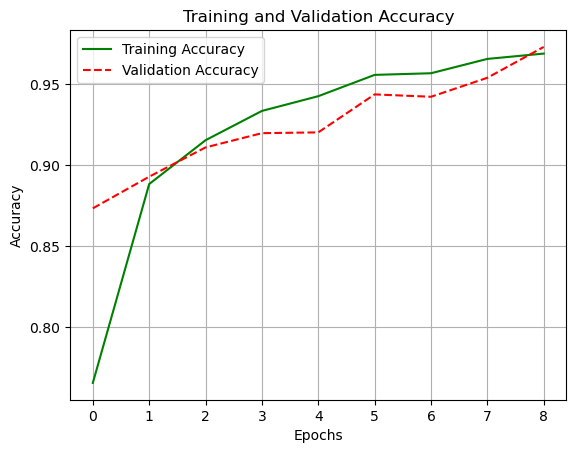

In [29]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss', color='blue', linestyle='-')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green', linestyle='-')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red', linestyle='--')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


## Convert Model

### TF-Lite

In [30]:
model.save('model.keras')

In [31]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\ACER\AppData\Local\Temp\tmp5aykh846\assets


INFO:tensorflow:Assets written to: C:\Users\ACER\AppData\Local\Temp\tmp5aykh846\assets


In [32]:
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

### TFJS

In [33]:
model.save('model.h5')

In [ ]:
#!pip install tensorflowjs==3.11

In [34]:
# Convert model.h5 to model
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

### TF-Serving

In [35]:
save_tf_serving = os.path.join('saved_model')
tf.saved_model.save(model, save_tf_serving)

INFO:tensorflow:Assets written to: saved_model\assets


INFO:tensorflow:Assets written to: saved_model\assets


## Inference

In [72]:
def preprocess_image(image_path, input_shape):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=input_shape[-1])
    image = tf.image.resize(image, (input_shape[1], input_shape[2]))
    image = tf.expand_dims(image, axis=0)
    return image

In [149]:
labels = ['Can', 'Plastic Bottle', 'UBC']

In [150]:
interpreter = tf.lite.Interpreter(model_path='model.tflite')
interpreter.allocate_tensors()

In [151]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [152]:
image_path = 'Inference/Images/image3.jpg'

In [153]:
input_data = preprocess_image(image_path, input_details[0]['shape'])

In [154]:
print("Shape of input_data:", input_data.shape)

Shape of input_data: (1, 224, 224, 3)


In [155]:
assert input_data.shape == tuple(input_details[0]['shape']), "Input dimensions mismatch"

In [156]:
interpreter.set_tensor(input_details[0]['index'], input_data)

# Run inference
interpreter.invoke()

In [157]:
output_data = interpreter.get_tensor(output_details[0]['index'])

In [158]:
print("Raw model output:", output_data)

Raw model output: [[0.00119658 0.9976006  0.00120285]]


In [159]:
predicted_label_index = np.argmax(output_data)

predicted_label = labels[predicted_label_index]

In [160]:
print(f"Predicted label: {predicted_label}")

Predicted label: Plastic Bottle


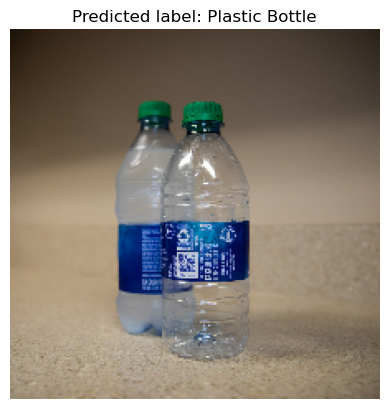

In [161]:
original_image = tf.io.read_file(image_path)
original_image = tf.image.decode_jpeg(original_image, channels=3)
original_image = tf.image.resize(original_image, (input_details[0]['shape'][1], input_details[0]['shape'][2]))

plt.imshow(original_image.numpy().astype(np.uint8))
plt.title(f"Predicted label: {predicted_label}")
plt.axis('off')
plt.show()

## Req.txt

In [162]:
!pip freeze > requirements.txt